# Hierarchical Multi-Agent System with LangGraph

This notebook implements a hierarchical agent system with the following structure:

```
Supervisor Agent
├── Team 1 (Research Team)
│   ├── Team 3 (Medical/Pharma Research)
│   └── Team 4 (Financial Research)
└── Team 2 (Report Team)
    ├── Team 5 (Summary Report)
    └── Team 6 (Document Report - PDF & DOCX)
```

## Installation and Setup

In [1]:
# Install required packages
!pip install langgraph langchain langchain-openai tavily-python beautifulsoup4 requests
!pip install python-docx reportlab pypdf2 langchain-community
!pip install langchain-experimental langsmith

## Import Required Libraries

In [2]:
import os
import json
import time
from datetime import datetime
from pathlib import Path
from typing import Dict, Any, List, Optional, TypedDict, Annotated

# LangGraph and LangChain imports
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_tavily import TavilySearch
from langchain_community.document_loaders import WebBaseLoader

# Document processing
from bs4 import BeautifulSoup
import requests
from docx import Document
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.enums import TA_JUSTIFY

# State management
from typing_extensions import TypedDict
import operator

USER_AGENT environment variable not set, consider setting it to identify your requests.


## Environment Configuration

Make sure to set up your environment variables:
- `OPENAI_API_KEY`: Your OpenAPI key
- `TAVILY_API_KEY`: Your Tavily API key for search functionality

In [3]:
# Configuration

# Set up environment variables
from dotenv import load_dotenv
load_dotenv()

# OpenAI API configuration
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
MODEL_NAME = "gpt-3.5-turbo"
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

if not OPENAI_API_KEY:
    print("Warning: OPENAI_API_KEY not found in environment variables")
if not TAVILY_API_KEY:
    print("Warning: TAVILY_API_KEY not found in environment variables")
    
# Create directories
os.makedirs("working_directory", exist_ok=True)
os.makedirs("output_directory", exist_ok=True)
print("Directories created successfully!")    

Directories created successfully!


## Helper Functions to cleanup output directories

In [4]:
import os
from datetime import datetime
import shutil
import time


def get_directory_stats():
    """Display current directory statistics."""
    directories = ["working_directory", "output_directory"]
    
    print("\n📊 DIRECTORY STATISTICS")
    print("=" * 40)
    
    total_files = 0
    total_size = 0
    
    for directory in directories:
        if os.path.exists(directory):
            files = os.listdir(directory)
            dir_size = 0
            
            for file in files:
                file_path = os.path.join(directory, file)
                if os.path.isfile(file_path):
                    dir_size += os.path.getsize(file_path)
            
            total_files += len(files)
            total_size += dir_size
            
            print(f"📁 {directory}/:")
            print(f"   Files: {len(files)}")
            print(f"   Size: {dir_size:,} bytes ({dir_size/1024/1024:.2f} MB)")
            
            if files:
                print("   Recent files:")
                # Show 3 most recent files
                recent_files = sorted(files, 
                                    key=lambda x: os.path.getmtime(os.path.join(directory, x)), 
                                    reverse=True)[:3]
                for file in recent_files:
                    file_path = os.path.join(directory, file)
                    file_size = os.path.getsize(file_path)
                    mod_time = datetime.fromtimestamp(os.path.getmtime(file_path))
                    print(f"     • {file} ({file_size:,} bytes) - {mod_time.strftime('%Y-%m-%d %H:%M')}")
            print()
    
    print(f"📈 TOTALS:")
    print(f"   Total Files: {total_files}")
    print(f"   Total Size: {total_size:,} bytes ({total_size/1024/1024:.2f} MB)")


def auto_cleanup():
    """Automatic cleanup without confirmation - use with caution!"""
    directories = ["working_directory", "output_directory"]
    
    print("🧹 Auto-cleanup starting...")
    
    deleted_files = 0
    for directory in directories:
        if os.path.exists(directory):
            files = os.listdir(directory)
            print(f"📁 Cleaning {directory}/ ({len(files)} files)")
            
            for file in files:
                try:
                    file_path = os.path.join(directory, file)
                    if os.path.isfile(file_path):
                        os.remove(file_path)
                        deleted_files += 1
                    elif os.path.isdir(file_path):
                        shutil.rmtree(file_path)
                        deleted_files += 1
                except Exception as e:
                    print(f"❌ Error deleting {file}: {str(e)}")
    
    print(f"✅ Auto-cleanup complete! Deleted {deleted_files} files.")


def cleanup_directories(working_dir=True, output_dir=True, confirm=True):
    """
    Clean up working and output directories before each run.
    
    Args:
        working_dir (bool): Clean working_directory if True
        output_dir (bool): Clean output_directory if True  
        confirm (bool): Ask for confirmation before deleting if True
    """
    
    directories_to_clean = []
    if working_dir:
        directories_to_clean.append("working_directory")
    if output_dir:
        directories_to_clean.append("output_directory")
    
    if not directories_to_clean:
        print("No directories selected for cleanup.")
        return
    
    # Show what will be deleted
    total_files = 0
    for directory in directories_to_clean:
        if os.path.exists(directory):
            files = os.listdir(directory)
            total_files += len(files)
            print(f"\n📁 {directory}/:")
            if files:
                for file in files:
                    file_path = os.path.join(directory, file)
                    file_size = os.path.getsize(file_path)
                    print(f"  - {file} ({file_size:,} bytes)")
            else:
                print("  - (empty)")
    
    if total_files == 0:
        print("\n✅ All directories are already clean!")
        return
    
    # Confirmation
    if confirm:
        print(f"\n⚠️  About to delete {total_files} files from {len(directories_to_clean)} directories.")
        response = input("Continue? (y/N): ").lower().strip()
        if response != 'y':
            print("❌ Cleanup cancelled.")
            return
    
    # Perform cleanup
    deleted_files = 0
    for directory in directories_to_clean:
        if os.path.exists(directory):
            files = os.listdir(directory)
            for file in files:
                try:
                    file_path = os.path.join(directory, file)
                    if os.path.isfile(file_path):
                        os.remove(file_path)
                        deleted_files += 1
                    elif os.path.isdir(file_path):
                        shutil.rmtree(file_path)
                        deleted_files += 1
                except Exception as e:
                    print(f"❌ Error deleting {file}: {str(e)}")
    
    print(f"✅ Cleanup complete! Deleted {deleted_files} files.")

    
def quick_clean():
    """Quick cleanup with confirmation."""
    cleanup_directories(confirm=True)    


def selective_cleanup():
    """Interactive cleanup with file selection."""
    directories = {
        "1": ("working_directory", "Working Directory (summaries)"),
        "2": ("output_directory", "Output Directory (PDF/DOCX)"),
        "3": ("both", "Both Directories")
    }
    
    print("\n🧹 SELECTIVE CLEANUP")
    print("=" * 30)
    for key, (path, desc) in directories.items():
        print(f"{key}. {desc}")
    
    choice = input("\nSelect option (1-3) or 'q' to quit: ").strip()
    
    if choice == 'q':
        print("❌ Cleanup cancelled.")
        return
    elif choice == "1":
        cleanup_directories(working_dir=True, output_dir=False)
    elif choice == "2":
        cleanup_directories(working_dir=False, output_dir=True)
    elif choice == "3":
        cleanup_directories(working_dir=True, output_dir=True)
    else:
        print("❌ Invalid selection.")


def cleanup_old_files(days_old=7):
    """
    Clean up files older than specified days.
    
    Args:
        days_old (int): Delete files older than this many days
    """
    
    cutoff_time = time.time() - (days_old * 24 * 60 * 60)
    directories = ["working_directory", "output_directory"]
    
    deleted_files = 0
    for directory in directories:
        if os.path.exists(directory):
            print(f"\n📁 Checking {directory}/ for files older than {days_old} days...")
            files = os.listdir(directory)
            
            for file in files:
                file_path = os.path.join(directory, file)
                if os.path.isfile(file_path):
                    file_time = os.path.getmtime(file_path)
                    if file_time < cutoff_time:
                        try:
                            file_size = os.path.getsize(file_path)
                            os.remove(file_path)
                            print(f"  🗑️  Deleted: {file} ({file_size:,} bytes)")
                            deleted_files += 1
                        except Exception as e:
                            print(f"  ❌ Error deleting {file}: {str(e)}")
    
    if deleted_files == 0:
        print(f"✅ No files older than {days_old} days found.")
    else:
        print(f"✅ Cleanup complete! Deleted {deleted_files} old files.")


## State Definition

In [5]:
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str
    query: str
    research_type: str  # "medical" or "financial"
    research_results: Dict[str, Any]
    summary_report: str
    report_filename: str
    final_reports: List[str]
    status: str

## Initialize Tools and LLM

In [6]:
# Initialize LLM
llm = ChatOpenAI(
    model=MODEL_NAME,
    api_key=OPENAI_API_KEY,
    temperature=0
)

# Initialize tools
# Tavily Search Tool
tavily_tool=TavilySearch(max_results=5,tavily_api_key=TAVILY_API_KEY)

print("Tools and LLM initialized successfully!")

Tools and LLM initialized successfully!


In [7]:
query = "Latest developments in Alzheimer's disease treatments and drug trials"
tavily_tool.invoke({"query": f"medical pharmaceutical {query}"})

{'query': "medical pharmaceutical Latest developments in Alzheimer's disease treatments and drug trials",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': "TRIALS UPDATE: The Latest Alzheimer's Drug Development News (Q1 2025)",
   'url': 'https://www.beingpatient.com/trials-update-2025-q1/',
   'content': "We've included all the latest news, including our reporting on early findings from the AD/PD 2025 conference in Vienna, where researchers shared updates on vaccine trials, small molecules, stem cell therapies, and more. On the disease modification front, several pills for Alzheimer's treatment are still in the race — or falling out of it.",
   'score': 0.75464433,
   'raw_content': None},
  {'title': "Alzheimer's Drug Development Pipeline: Positive Results, New Insight ...",
   'url': 'https://www.unlv.edu/news/release/alzheimers-drug-development-pipeline-positive-results-new-insight-position-2024',
   'content': 'The world of Alzheimer\'s treatmen

## Supervisor Agent

In [8]:
def supervisor_agent(state: AgentState) -> AgentState:
    """Main supervisor that routes tasks to appropriate teams."""
    
    messages = state.get("messages", [])
    query = state.get("query", "")
    status = state.get("status", "start")
    
    if status == "start":
        # Determine research type based on query
        prompt = f"""
        Analyze the following query and determine if it's related to:
        1. Medical/Pharmaceutical research (respond with 'medical')
        2. Financial research (respond with 'financial')
        
        Query: {query}
        
        Respond with only 'medical' or 'financial'.
        """
        
        response = llm.invoke([HumanMessage(content=prompt)])
        research_type = response.content.lower().strip()
        
        print(f"Supervisor: Determined research type as '{research_type}'")
        
        return {
            **state,
            "research_type": research_type,
            "next": "team1_coordinator",
            "status": "research_assigned",
            "messages": messages + [AIMessage(content=f"Routing to {research_type} research team")]
        }
    
    elif status == "research_complete":
        print("Supervisor: Research complete, routing to report generation")
        return {
            **state,
            "next": "team2_coordinator",
            "status": "report_assigned"
        }
    
    elif status == "reports_complete":
        print("Supervisor: All reports generated successfully. Process complete.")
        return {
            **state,
            "next": END,
            "status": "complete"
        }
    
    return state

## Team 1 Coordinator (Research Team)

In [9]:
def team1_coordinator(state: AgentState) -> AgentState:
    """Coordinates between Team 3 (Medical) and Team 4 (Financial) research teams."""
    
    research_type = state.get("research_type", "")
    
    if research_type == "medical":
        print("Team 1 Coordinator: Routing to Medical/Pharma Research Team (Team 3)")
        return {
            **state,
            "next": "team3_medical_research"
        }
    elif research_type == "financial":
        print("Team 1 Coordinator: Routing to Financial Research Team (Team 4)")
        return {
            **state,
            "next": "team4_financial_research"
        }
    
    return state

## Team 3: Medical/Pharma Research

In [10]:
def team3_medical_research(state: AgentState) -> AgentState:
    """Team 3: Medical/Pharmaceutical research using Tavily and web scraping."""
    
    query = state.get("query", "")
    messages = state.get("messages", [])
    
    print(f"Team 3 (Medical Research): Starting research on '{query}'")
    
    try:
        # Step 1: Tavily search
        search_results = tavily_tool.invoke({"query": f"medical pharmaceutical {query}"}).get('results', [])
        print(f"Team 3: Found {len(search_results)} search results")

        # Step 2: Web scraping for detailed information
        detailed_info = []
        
        for result in search_results[:3]:  # Limit to top 3 results
            try:
                url = result.get('url', '')
                if url:
                    print(f"Team 3: Scraping {url}")
                    loader = WebBaseLoader(url)
                    docs = loader.load()
                    
                    if docs:
                        # Use BeautifulSoup for additional processing
                        response = requests.get(url, timeout=10)
                        soup = BeautifulSoup(response.content, 'html.parser')
                        
                        # Extract relevant text
                        text_content = soup.get_text()
                        # Clean and limit text
                        clean_text = ' '.join(text_content.split())[:2000]
                        
                        detailed_info.append({
                            'url': url,
                            'title': result.get('title', 'No title'),
                            'content': clean_text,
                            'snippet': result.get('content', '')
                        })
            except Exception as e:
                print(f"Team 3: Error scraping {url}: {str(e)}")
                continue
        
        research_results = {
            'team': 'medical_research',
            'query': query,
            'search_results': search_results,
            'detailed_info': detailed_info,
            'timestamp': datetime.now().isoformat()
        }
        
        print(f"Team 3: Research completed with {len(detailed_info)} detailed sources")
        
        return {
            **state,
            "research_results": research_results,
            "next": "supervisor",
            "status": "research_complete",
            "messages": messages + [AIMessage(content=f"Medical research completed for: {query}")]
        }
        
    except Exception as e:
        print(f"Team 3: Error during research: {str(e)}")
        return {
            **state,
            "research_results": {'error': str(e), 'team': 'medical_research'},
            "next": "supervisor",
            "status": "research_error"
        }

## Team 4: Financial Research

In [11]:
def team4_financial_research(state: AgentState) -> AgentState:
    """Team 4: Financial research using Tavily and web scraping."""
    
    query = state.get("query", "")
    messages = state.get("messages", [])
    
    print(f"Team 4 (Financial Research): Starting research on '{query}'")
    
    try:
        # Step 1: Tavily search
        search_results = tavily_tool.invoke({"query": f"financial market analysis {query}"}).get('results', [])
        print(f"Team 4: Found {len(search_results)} search results")
        
        # Step 2: Web scraping for detailed information
        detailed_info = []
        
        for result in search_results[:3]:  # Limit to top 3 results
            try:
                url = result.get('url', '')
                if url:
                    print(f"Team 4: Scraping {url}")
                    loader = WebBaseLoader(url)
                    docs = loader.load()
                    
                    if docs:
                        # Use BeautifulSoup for additional processing
                        response = requests.get(url, timeout=10)
                        soup = BeautifulSoup(response.content, 'html.parser')
                        
                        # Extract relevant text
                        text_content = soup.get_text()
                        # Clean and limit text
                        clean_text = ' '.join(text_content.split())[:2000]
                        
                        detailed_info.append({
                            'url': url,
                            'title': result.get('title', 'No title'),
                            'content': clean_text,
                            'snippet': result.get('content', '')
                        })
            except Exception as e:
                print(f"Team 4: Error scraping {url}: {str(e)}")
                continue
        
        research_results = {
            'team': 'financial_research',
            'query': query,
            'search_results': search_results,
            'detailed_info': detailed_info,
            'timestamp': datetime.now().isoformat()
        }
        
        print(f"Team 4: Research completed with {len(detailed_info)} detailed sources")
        
        return {
            **state,
            "research_results": research_results,
            "next": "supervisor",
            "status": "research_complete",
            "messages": messages + [AIMessage(content=f"Financial research completed for: {query}")]
        }
        
    except Exception as e:
        print(f"Team 4: Error during research: {str(e)}")
        return {
            **state,
            "research_results": {'error': str(e), 'team': 'financial_research'},
            "next": "supervisor",
            "status": "research_error"
        }

## Team 2 Coordinator (Report Team)

In [12]:
def team2_coordinator(state: AgentState) -> AgentState:
    """Coordinates between Team 5 (Summary) and Team 6 (Document) report teams."""
    
    print("Team 2 Coordinator: Starting report generation process")
    return {
        **state,
        "next": "team5_summary_report"
    }

## Team 5: Summary Report

In [13]:
def team5_summary_report(state: AgentState) -> AgentState:
    """Team 5: Creates summary report from research results."""
    
    research_results = state.get("research_results", {})
    query = state.get("query", "")
    messages = state.get("messages", [])
    
    print("Team 5: Creating summary report")
    
    try:
        # Prepare research data for summarization
        research_content = ""
        
        if 'detailed_info' in research_results:
            for info in research_results['detailed_info']:
                research_content += f"\n\nSource: {info['title']}\nURL: {info['url']}\nContent: {info['snippet']}\n"
        
        # Create summary using LLM
        prompt = f"""
        Create a comprehensive summary report based on the following research data:
        
        Query: {query}
        Research Type: {research_results.get('team', 'Unknown')}
        
        Research Content:
        {research_content}
        
        Please create a structured summary report with:
        1. Executive Summary
        2. Key Findings
        3. Detailed Analysis
        4. Sources
        5. Conclusions and Recommendations
        
        Make it professional and comprehensive.
        """
        
        response = llm.invoke([HumanMessage(content=prompt)])
        summary_report = response.content
        
        # Generate filename
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        safe_query = "".join(c for c in query if c.isalnum() or c in (' ', '-', '_')).rstrip()[:50]
        report_filename = f"{safe_query}_{timestamp}"
        
        # Save summary report to working directory
        report_path = os.path.join("working_directory", f"{report_filename}_summary.txt")
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write(summary_report)
        
        print(f"Team 5: Summary report saved to {report_path}")
        
        return {
            **state,
            "summary_report": summary_report,
            "report_filename": report_filename,
            "next": "team6_document_report",
            "messages": messages + [AIMessage(content=f"Summary report created: {report_filename}")]
        }
        
    except Exception as e:
        print(f"Team 5: Error creating summary report: {str(e)}")
        return {
            **state,
            "summary_report": f"Error creating summary: {str(e)}",
            "next": "team6_document_report"
        }

## Team 6: Document Report (PDF & DOCX)

In [14]:
def team6_document_report(state: AgentState) -> AgentState:
    """Team 6: Creates PDF and DOCX documents from summary report."""
    
    summary_report = state.get("summary_report", "")
    report_filename = state.get("report_filename", "report")
    messages = state.get("messages", [])
    
    print("Team 6: Creating PDF and DOCX documents")
    
    final_reports = []
    
    try:
        # Create PDF report
        pdf_path = os.path.join("output_directory", f"{report_filename}.pdf")
        
        doc = SimpleDocTemplate(pdf_path, pagesize=letter)
        styles = getSampleStyleSheet()
        story = []
        
        # Add title
        title_style = ParagraphStyle(
            'CustomTitle',
            parent=styles['Heading1'],
            fontSize=18,
            alignment=TA_JUSTIFY,
            spaceAfter=30,
        )
        story.append(Paragraph(f"Research Report: {report_filename}", title_style))
        story.append(Spacer(1, 12))
        
        # Add content
        content_style = ParagraphStyle(
            'CustomContent',
            parent=styles['Normal'],
            fontSize=11,
            alignment=TA_JUSTIFY,
            spaceAfter=12,
        )
        
        # Split content into paragraphs
        paragraphs = summary_report.split('\n\n')
        for para in paragraphs:
            if para.strip():
                story.append(Paragraph(para.strip(), content_style))
                story.append(Spacer(1, 6))
        
        doc.build(story)
        final_reports.append(pdf_path)
        print(f"Team 6: PDF report created at {pdf_path}")
        
    except Exception as e:
        print(f"Team 6: Error creating PDF: {str(e)}")
    
    try:
        # Create DOCX report
        docx_path = os.path.join("output_directory", f"{report_filename}.docx")
        
        doc = Document()
        
        # Add title
        title = doc.add_heading(f"Research Report: {report_filename}", 0)
        
        # Add content
        paragraphs = summary_report.split('\n\n')
        for para in paragraphs:
            if para.strip():
                # Check if it's a heading (starts with a number or capital letters)
                if para.strip().split('.')[0].isdigit() or para.strip().isupper():
                    doc.add_heading(para.strip(), level=2)
                else:
                    doc.add_paragraph(para.strip())
        
        doc.save(docx_path)
        final_reports.append(docx_path)
        print(f"Team 6: DOCX report created at {docx_path}")
        
    except Exception as e:
        print(f"Team 6: Error creating DOCX: {str(e)}")
    
    print(f"Team 6: Document generation complete. Created {len(final_reports)} files.")
    
    return {
        **state,
        "final_reports": final_reports,
        "next": "supervisor",
        "status": "reports_complete",
        "messages": messages + [AIMessage(content=f"Final reports created: {', '.join(final_reports)}")]
    }

## Build the Complete Graph

In [15]:
def build_hierarchical_agent_graph():
    """Build the hierarchical agent graph."""
    
    # Create the state graph
    workflow = StateGraph(AgentState)
    
    # Add nodes
    workflow.add_node("supervisor", supervisor_agent)
    workflow.add_node("team1_coordinator", team1_coordinator)
    workflow.add_node("team3_medical_research", team3_medical_research)
    workflow.add_node("team4_financial_research", team4_financial_research)
    workflow.add_node("team2_coordinator", team2_coordinator)
    workflow.add_node("team5_summary_report", team5_summary_report)
    workflow.add_node("team6_document_report", team6_document_report)
    
    # Define the routing logic
    def route_supervisor(state):
        return state["next"]
    
    def route_team1(state):
        return state["next"]
    
    def route_team2(state):
        return state["next"]
    
    # Set entry point
    workflow.set_entry_point("supervisor")
    
    # Add conditional edges
    workflow.add_conditional_edges(
        "supervisor",
        route_supervisor,
        {
            "team1_coordinator": "team1_coordinator",
            "team2_coordinator": "team2_coordinator",
            END: END
        }
    )
    
    workflow.add_conditional_edges(
        "team1_coordinator",
        route_team1,
        {
            "team3_medical_research": "team3_medical_research",
            "team4_financial_research": "team4_financial_research"
        }
    )
    
    workflow.add_conditional_edges(
        "team2_coordinator",
        route_team2,
        {
            "team5_summary_report": "team5_summary_report"
        }
    )
    
    # Add edges back to supervisor
    workflow.add_edge("team3_medical_research", "supervisor")
    workflow.add_edge("team4_financial_research", "supervisor")
    workflow.add_edge("team5_summary_report", "team6_document_report")
    workflow.add_edge("team6_document_report", "supervisor")
    
    return workflow.compile()

print("Graph structure defined successfully!")

Graph structure defined successfully!


## Helper Functions

In [16]:
def run_hierarchical_agent(query: str, research_type: str = None, cleanup=True):
    """Run the hierarchical agent system with a given query."""
    
    print(f"\n{'='*60}")
    print(f"STARTING HIERARCHICAL AGENT SYSTEM")
    print(f"Query: {query}")
    print(f"{'='*60}\n")
    
    # Cleanup working and output directories
    if cleanup:
        auto_cleanup()
        
    # Build the graph
    app = build_hierarchical_agent_graph()
    
    # Print App
    from IPython.display import display,Image
    display(Image(app.get_graph().draw_mermaid_png()))
    
    # Initialize state
    initial_state = {
        "messages": [HumanMessage(content=query)],
        "query": query,
        "next": "supervisor",
        "research_type": research_type or "",
        "research_results": {},
        "summary_report": "",
        "report_filename": "",
        "final_reports": [],
        "status": "start"
    }
    
    # Run the workflow
    try:
        final_state = app.invoke(initial_state)
        
        print(f"\n{'='*60}")
        print("PROCESS COMPLETED SUCCESSFULLY!")
        print(f"Status: {final_state.get('status', 'Unknown')}")
        print(f"Final Reports Generated: {len(final_state.get('final_reports', []))}")
        
        for report in final_state.get('final_reports', []):
            print(f"  - {report}")
        
        print(f"{'='*60}\n")
        
        return final_state
        
    except Exception as e:
        print(f"\nERROR: {str(e)}")
        print("Please check your API keys and try again.")
        return None

## Testing Functions

In [17]:
def test_medical_query():
    """Test with a medical query"""
    medical_query = "Latest developments in Alzheimer's disease treatments and drug trials"
    result = run_hierarchical_agent(medical_query)

    if result:
        print("\nMedical research completed successfully!")
        print(f"Research type: {result.get('research_type')}")
        print(f"Summary report length: {len(result.get('summary_report', ''))} characters")
    return result

def test_financial_query():
    """Test with a financial query"""
    financial_query = "Impact of Federal Reserve interest rate changes on technology stock prices"
    result = run_hierarchical_agent(financial_query)

    if result:
        print("\nFinancial research completed successfully!")
        print(f"Research type: {result.get('research_type')}")
        print(f"Summary report length: {len(result.get('summary_report', ''))} characters")
    return result

## System Validation

In [18]:
def validate_system_setup():
    """Validate that the system is properly set up."""
    print("\nVALIDATING SYSTEM SETUP")
    print("=" * 40)
    
    # Check API keys
    openai_key = os.environ.get("OPENAI_API_KEY", "")
    tavily_key = os.environ.get("TAVILY_API_KEY", "")
    
    if openai_key:
        print("OpenAI API Key: ✓ Set")
    else:
        print("OpenAI API Key: ✗ Not set or default")  
        
    if tavily_key:
        print("Tavily API Key: ✓ Set")
    else:
        print("Tavily API Key: ✗ Not set or default")         
        
    # print(f"OpenAI API Key: {'✓ Set' if openai_key and openai_key != 'your-openai-api-key-here' else '✗ Not set or default'}")
    # print(f"Tavily API Key: {'✓ Set' if tavily_key and tavily_key != 'your-tavily-api-key-here' else '✗ Not set or default'}")
    
    # Check directories
    working_dir = os.path.exists("working_directory")
    output_dir = os.path.exists("output_directory")
    
    print(f"Working Directory: {'✓ Exists' if working_dir else '✗ Missing'}")
    print(f"Output Directory: {'✓ Exists' if output_dir else '✗ Missing'}")
    
    # Test LLM connection
    try:
        test_llm = ChatOpenAI(model=MODEL_NAME, api_key=OPENAI_API_KEY, temperature=0)
        test_response = test_llm.invoke([HumanMessage(content="Hello")])
        print(f"LLM Connection: ✓ Working")
    except Exception as e:
        print(f"LLM Connection: ✗ Error - {str(e)[:100]}")
    
    # Test Tavily connection
    try:
        test_tavily = TavilySearch(max_results=5,tavily_api_key=TAVILY_API_KEY)
        test_search = test_tavily.invoke({"query": "test"})
        print(f"Tavily Connection: ✓ Working")
    except Exception as e:
        print(f"Tavily Connection: ✗ Error - {str(e)[:100]}")

# Run validation on startup
validate_system_setup()


VALIDATING SYSTEM SETUP
OpenAI API Key: ✓ Set
Tavily API Key: ✓ Set
Working Directory: ✓ Exists
Output Directory: ✓ Exists
LLM Connection: ✓ Working
Tavily Connection: ✓ Working


## File Management

In [19]:
def list_generated_files():
    """List all files in working and output directories"""
    print("\nGenerated Files:")
    print("\nWorking Directory:")
    try:
        working_files = os.listdir("working_directory")
        for file in working_files:
            file_path = os.path.join("working_directory", file)
            file_size = os.path.getsize(file_path)
            print(f"  - {file} ({file_size} bytes)")
    except FileNotFoundError:
        print("  - No files found")
    
    print("\nOutput Directory:")
    try:
        output_files = os.listdir("output_directory")
        for file in output_files:
            file_path = os.path.join("output_directory", file)
            file_size = os.path.getsize(file_path)
            print(f"  - {file} ({file_size} bytes)")
    except FileNotFoundError:
        print("  - No files found")

def display_latest_summary():
    """Display content of the latest summary report"""
    try:
        working_files = [f for f in os.listdir("working_directory") if f.endswith("_summary.txt")]
        if working_files:
            latest_file = max(working_files, key=lambda x: os.path.getctime(os.path.join("working_directory", x)))
            print(f"\nLatest Summary Report: {latest_file}")
            print("=" * 60)
            
            with open(os.path.join("working_directory", latest_file), 'r', encoding='utf-8') as f:
                content = f.read()
                # Display first 1000 characters
                print(content[:1000] + "..." if len(content) > 1000 else content)
        else:
            print("No summary reports found.")
    except Exception as e:
        print(f"Error reading summary: {str(e)}")

## Quick Start Guide

In [20]:
def main():
    """Main function with usage instructions."""
    print("\n" + "=" * 60)
    print("HIERARCHICAL MULTI-AGENT SYSTEM")
    print("=" * 60)
    
    print("\n🚀 QUICK START:")
    print("1. Set your API keys in the environment setup section above")
    print("2. Run: test_medical_query() or test_financial_query()")
    print("3. Check results: list_generated_files()")
    
    print("\n📋 AVAILABLE FUNCTIONS:")
    print("• test_medical_query() - Test medical research")
    print("• test_financial_query() - Test financial research")
    print("• run_hierarchical_agent('your query') - Custom research")
    print("• list_generated_files() - Show all generated files")
    print("• display_latest_summary() - Preview latest report")
    print("• validate_system_setup() - Check system status")
    
    print("\n📁 OUTPUT DIRECTORIES:")
    print("• working_directory/ - Summary text files")
    print("• output_directory/ - Final PDF and DOCX reports")
    
    print("\n🔄 SYSTEM WORKFLOW:")
    print("Query → Supervisor → Research Team → Report Team → Documents")
    
    print("\n✅ System ready! Choose a function above to get started.")
    print("=" * 60)

# Run main on startup
main()


HIERARCHICAL MULTI-AGENT SYSTEM

🚀 QUICK START:
1. Set your API keys in the environment setup section above
2. Run: test_medical_query() or test_financial_query()
3. Check results: list_generated_files()

📋 AVAILABLE FUNCTIONS:
• test_medical_query() - Test medical research
• test_financial_query() - Test financial research
• run_hierarchical_agent('your query') - Custom research
• list_generated_files() - Show all generated files
• display_latest_summary() - Preview latest report
• validate_system_setup() - Check system status

📁 OUTPUT DIRECTORIES:
• working_directory/ - Summary text files
• output_directory/ - Final PDF and DOCX reports

🔄 SYSTEM WORKFLOW:
Query → Supervisor → Research Team → Report Team → Documents

✅ System ready! Choose a function above to get started.


## Cleanup Output Directories System Demo

In [21]:
print("🧹 CLEANUP SYSTEM DEMONSTRATION")
print("=" * 50)

# Show current directory status
get_directory_stats()

print("\n💡 CLEANUP OPTIONS:")
print("\n1. AUTOMATIC CLEANUP (recommended):")
print("   • run_hierarchical_agent(query, cleanup=True)  # Default")
print("   • test_medical_query(cleanup_first=True)  # Default")

print("\n2. MANUAL CLEANUP:")
print("   • cleanup_directories()  # Interactive with confirmation")
print("   • auto_cleanup()  # Automatic without confirmation")
print("   • selective_cleanup()  # Choose directories")

print("\n3. ADVANCED CLEANUP:")
print("   • cleanup_old_files(days=7)  # Only old files")
print("   • get_directory_stats()  # Check current status")
print("   • quick_clean()  # Quick with confirmation")

print("\n⚠️  EXAMPLES:")
print("# Clean before running (recommended)")
print("# result = run_hierarchical_agent('your query', cleanup=True)")
print("")
print("# Manual cleanup with confirmation")
print("# cleanup_directories()")
print("")
print("# Check what's in directories")
print("# get_directory_stats()")
print("")
print("# Clean files older than 3 days")
print("# cleanup_old_files(days=3)")

print("\n✅ Cleanup system ready! Use any function above to manage files.")

🧹 CLEANUP SYSTEM DEMONSTRATION

📊 DIRECTORY STATISTICS
📁 working_directory/:
   Files: 2
   Size: 5,817 bytes (0.01 MB)
   Recent files:
     • Impact of Federal Reserve interest rate changes on_20250701_004056_summary.txt (3,108 bytes) - 2025-07-01 00:40
     • Latest developments in Alzheimers disease treatmen_20250701_003452_summary.txt (2,709 bytes) - 2025-07-01 00:34

📁 output_directory/:
   Files: 4
   Size: 82,572 bytes (0.08 MB)
   Recent files:
     • Impact of Federal Reserve interest rate changes on_20250701_004056.docx (37,818 bytes) - 2025-07-01 00:40
     • Impact of Federal Reserve interest rate changes on_20250701_004056.pdf (3,557 bytes) - 2025-07-01 00:40
     • Latest developments in Alzheimers disease treatmen_20250701_003452.docx (37,768 bytes) - 2025-07-01 00:34

📈 TOTALS:
   Total Files: 6
   Total Size: 88,389 bytes (0.08 MB)

💡 CLEANUP OPTIONS:

1. AUTOMATIC CLEANUP (recommended):
   • run_hierarchical_agent(query, cleanup=True)  # Default
   • test_medical_que


STARTING HIERARCHICAL AGENT SYSTEM
Query: Latest developments in Alzheimer's disease treatments and drug trials

🧹 Auto-cleanup starting...
📁 Cleaning working_directory/ (2 files)
📁 Cleaning output_directory/ (4 files)
✅ Auto-cleanup complete! Deleted 6 files.


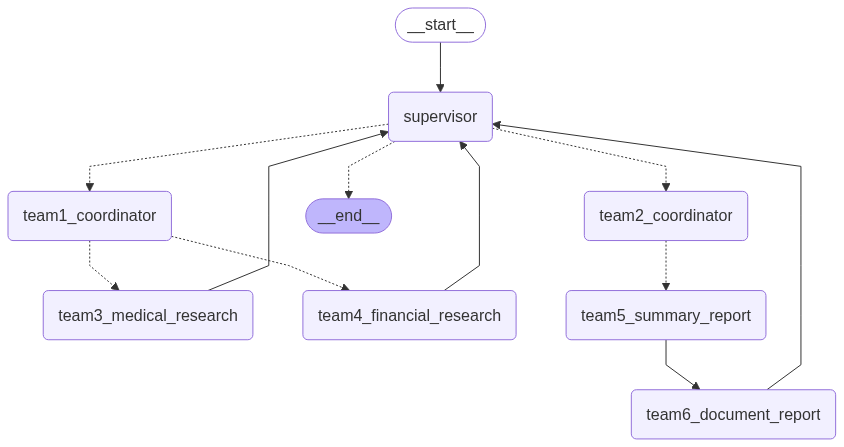

Supervisor: Determined research type as 'medical'
Team 1 Coordinator: Routing to Medical/Pharma Research Team (Team 3)
Team 3 (Medical Research): Starting research on 'Latest developments in Alzheimer's disease treatments and drug trials'
Team 3: Found 5 search results
Team 3: Scraping https://www.beingpatient.com/trials-update-2025-q1/
Team 3: Scraping https://www.unlv.edu/news/release/alzheimers-drug-development-pipeline-positive-results-new-insight-position-2024
Team 3: Scraping https://alz-journals.onlinelibrary.wiley.com/doi/10.1002/trc2.70098
Team 3: Research completed with 3 detailed sources
Supervisor: Research complete, routing to report generation
Team 2 Coordinator: Starting report generation process
Team 5: Creating summary report
Team 5: Summary report saved to working_directory\Latest developments in Alzheimers disease treatmen_20250701_012056_summary.txt
Team 6: Creating PDF and DOCX documents
Team 6: PDF report created at output_directory\Latest developments in Alzheime

{'messages': [HumanMessage(content="Latest developments in Alzheimer's disease treatments and drug trials", additional_kwargs={}, response_metadata={}),
  HumanMessage(content="Latest developments in Alzheimer's disease treatments and drug trials", additional_kwargs={}, response_metadata={}),
  AIMessage(content='Routing to medical research team', additional_kwargs={}, response_metadata={}),
  HumanMessage(content="Latest developments in Alzheimer's disease treatments and drug trials", additional_kwargs={}, response_metadata={}),
  HumanMessage(content="Latest developments in Alzheimer's disease treatments and drug trials", additional_kwargs={}, response_metadata={}),
  AIMessage(content='Routing to medical research team', additional_kwargs={}, response_metadata={}),
  HumanMessage(content="Latest developments in Alzheimer's disease treatments and drug trials", additional_kwargs={}, response_metadata={}),
  HumanMessage(content="Latest developments in Alzheimer's disease treatments and

In [22]:
test_medical_query()


STARTING HIERARCHICAL AGENT SYSTEM
Query: Impact of Federal Reserve interest rate changes on technology stock prices

🧹 Auto-cleanup starting...
📁 Cleaning working_directory/ (1 files)
📁 Cleaning output_directory/ (2 files)
✅ Auto-cleanup complete! Deleted 3 files.


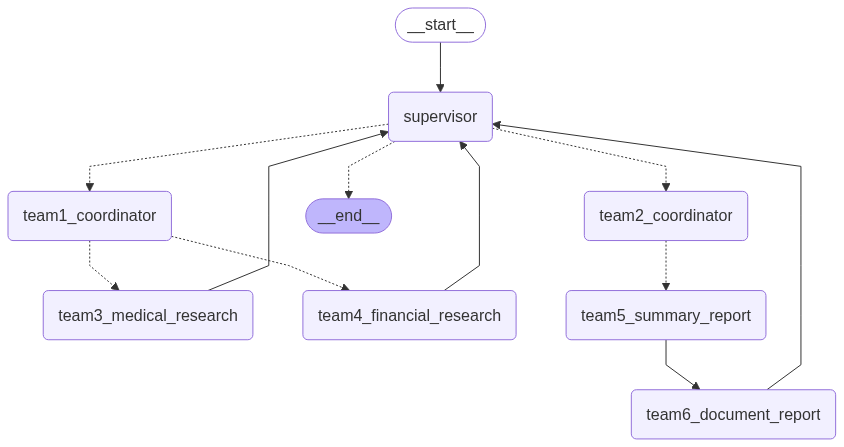

Supervisor: Determined research type as 'financial'
Team 1 Coordinator: Routing to Financial Research Team (Team 4)
Team 4 (Financial Research): Starting research on 'Impact of Federal Reserve interest rate changes on technology stock prices'
Team 4: Found 5 search results
Team 4: Scraping https://www.onwish.ai/insights/federal-reserve-rate-decisions-impact-on-tech-stocks
Team 4: Scraping https://www.researchgate.net/publication/382573271_The_Impact_of_Fed_Rate_Hikes_on_Tech_Company_Stock_Prices_Microsoft_as_an_Example
Team 4: Scraping https://www.abacademies.org/articles/the-impact-of-interest-rate-changes-on-stock-market-performance-an-empirical-analysis.pdf


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Team 4: Research completed with 3 detailed sources
Supervisor: Research complete, routing to report generation
Team 2 Coordinator: Starting report generation process
Team 5: Creating summary report
Team 5: Summary report saved to working_directory\Impact of Federal Reserve interest rate changes on_20250701_012217_summary.txt
Team 6: Creating PDF and DOCX documents
Team 6: PDF report created at output_directory\Impact of Federal Reserve interest rate changes on_20250701_012217.pdf
Team 6: DOCX report created at output_directory\Impact of Federal Reserve interest rate changes on_20250701_012217.docx
Team 6: Document generation complete. Created 2 files.
Supervisor: All reports generated successfully. Process complete.

PROCESS COMPLETED SUCCESSFULLY!
Status: complete
Final Reports Generated: 2
  - output_directory\Impact of Federal Reserve interest rate changes on_20250701_012217.pdf
  - output_directory\Impact of Federal Reserve interest rate changes on_20250701_012217.docx


Financial 

{'messages': [HumanMessage(content='Impact of Federal Reserve interest rate changes on technology stock prices', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Impact of Federal Reserve interest rate changes on technology stock prices', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Routing to financial research team', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Impact of Federal Reserve interest rate changes on technology stock prices', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Impact of Federal Reserve interest rate changes on technology stock prices', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Routing to financial research team', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Impact of Federal Reserve interest rate changes on technology stock prices', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Impact of Federal Reserve in

In [23]:
test_financial_query()


STARTING HIERARCHICAL AGENT SYSTEM
Query: What is the main difference between agents written in LangGraph and those written in N8N?

🧹 Auto-cleanup starting...
📁 Cleaning working_directory/ (1 files)
📁 Cleaning output_directory/ (2 files)
✅ Auto-cleanup complete! Deleted 3 files.


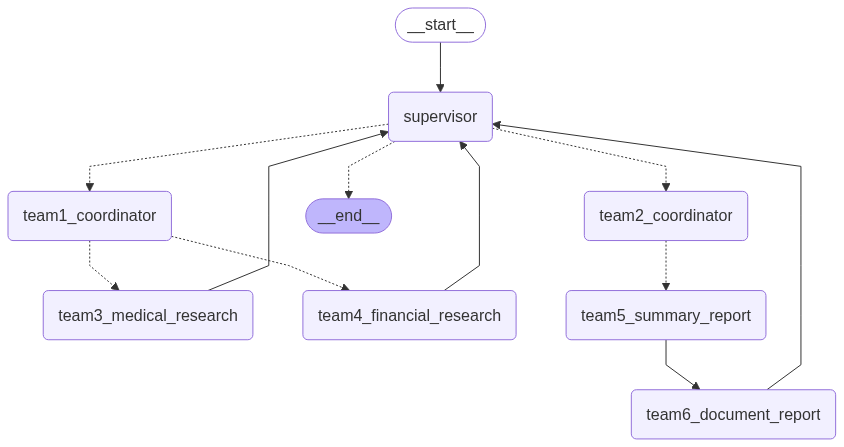

Supervisor: Determined research type as 'neither.'

ERROR: 'team1_coordinator'
Please check your API keys and try again.


In [24]:
run_hierarchical_agent('What is the main difference between agents written in LangGraph and those written in N8N?')

In [25]:
list_generated_files()


Generated Files:

Working Directory:

Output Directory:


In [26]:
display_latest_summary()

No summary reports found.


In [27]:
validate_system_setup()


VALIDATING SYSTEM SETUP
OpenAI API Key: ✓ Set
Tavily API Key: ✓ Set
Working Directory: ✓ Exists
Output Directory: ✓ Exists
LLM Connection: ✓ Working
Tavily Connection: ✓ Working
